![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# EPA Dasymetric Tool Implementation for Population

 - Sign up to the [VA Datacube](https://datacube.vmasc.org/) to run this notebook interactively from a browser
 - <b>Compatibility</b>: Notebook currently compatible with VA Datacube Sandbox environments    

 - <b>Products used</b>:  
    - NLCD 2019 Dataset
 
 
 - <b>Special requirements:</b> There are no special requirements for this notebook
 
 - <b>Prerequisites:</b> Reviewing the "CensusData.ipynb" data cube notebook would be helpful but not required. 
 
 - <b>Notebook Use:</b> If you would like to modify and save this notebook, please copy and paste it into your own folder on the data cube and make sure to enable your version control.


## Background


The Dasymetric mapping technique is used to help address the question of how many people within a census block or tract live in or near areas of exposure, such as living in flood plains or near mosquito habitat. Dasymetric involves taking population data from either a block or tract level and redistributing it using ancillary data, namely land cover [(Mennis, 2003)](http://dx.doi.org/10.1111/0033-0124.10042). The user will make assumptions where people do and do not live for the different land cover classes, such as <i>not living</i> in open water. As such, you can assign density to other land classes, such as deciduous forest [(Mennis and Hultgren, 2006)](http://dx.doi.org/10.1559/152304006779077309). Aside from land cover, other ancillary data can include using a 30-m gridded impervious surface layer [(Swanwick et al., 2022)](https://www.nature.com/articles/s41597-022-01603-z). Below, we will follow a technique known as Intelligent Dasymetric Mapping (IDM) used by the U.S. Environmental Protection Agency (EPA). Their work can be found below, along with an overview and location of their code.

## Overview
Dasymetric mapping is a geospatial technique that uses information such as land cover types to more accurately distribute data within selected boundaries like census blocks.

The IDM Toolbox is available to download. This toolbox uses Python 3.6 and open source GIS libraries. An additional version is available as a [toolbox for ESRI ArcGIS Pro](https://github.com/USEPA/Dasymetric-Toolbox-ArcGISPro)


<figure>
  <img src="https://www.epa.gov/sites/default/files/2015-07/dasymetric_728x210.jpg" alt="Dasymetric example image"/>
  <figcaption><sup>The image on the left shows a map of the population by block group based solely on the census data. The image on the right shows the dasymetric population allocation for several block groups in Tampa, Fla.</sup></figcaption>  
</figure>
<br>


-   EnviroAtlas researchers use the dasymetric data to calculate the distribution of ecosystem services, and other metrics including walking distances, viewsheds, resource use, and exposure potential.
-   For more information on the Dasymetric data created for EnviroAtlas, see our [website](https://www.epa.gov/enviroatlas/dasymetric-toolbox) or  [Dasymetric Allocation of Population Fact Sheet](https://enviroatlas.epa.gov/enviroatlas/DataFactSheets/pdf/Supplemental/DasymetricAllocationofPopulation.pdf).

The EnviroAtlas Intelligent Dasymetric Toolbox for Open Source GIS is currently in development. The most recent release for ESRI ArcMap 10.3 is available at [https://www.epa.gov/enviroatlas/dasymetric-toolbox](https://www.epa.gov/enviroatlas/dasymetric-toolbox).


- Name: Open source Intelligent Dasymetric Mapping (IDM) script

- Author: Anam Khan

- Date: 5/1/2019

- Description: Intelligent Dasymetric Mapping (IDM) disaggregates population 
    counts enumerated by vector source units to the spatial resolution of a 
    categorical ancillary raster containing classes that are indicative of the 
    spatial distribution of population within the source units. This script is 
    an open source version of the EnviroAtlas IDM toolbox developed by 
    Torrin Hultgren for ArcMap: https://www.epa.gov/enviroatlas/dasymetric-toolbox.
    This version follows the publication by Mennis and Hultgren (2006) with the
    exception that class densities for unsampled ancillary classes are calculated
    using census polygons where the population estimated for sampled/preset 
    ancillary classes did not exceed the census population.

- Modified on: 04/12/2024
- By: Blake Steiner
- Purpose: To create a Virginia Datacube friendly version for population vulnerability in other notebooks.

## Description

This notebook will introduce you to calling U.S. Census data for the City of Chesapeake, calculating a new census variable, and applying the IDM technique to map out medically fragile populations. Below is a broad overview of what we will do. 

1. Load the necessary libraries
2. Call in and visualize census data
3. Call in and visualize NLCD 
4. View the landcover weights
5. Run and visualize IDM function for the City of Chesapeake

---------------------------------------------------------------------------------------------------------------------------

## Getting started


To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. Please feel free to explore the pop-ups for some of the interactive maps you will create. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [1]:
%matplotlib inline

import datacube
from deafrica_tools.plotting import rgb, display_map
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os, sys, json
from osgeo import gdal
from osgeo import ogr
import numpy as np
import pandas as pd
import geopandas as gp
import argparse as ap
from matplotlib.colors import ListedColormap
import geopandas as gpd
import rioxarray
import matplotlib.colors as colors
from matplotlib.patches import Patch
import xarray as xr


#Work with geotiffs
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show


#Census and data exploration
import pygeoda
from pygris import blocks, block_groups
from pygris.data import get_census
from libpysal import weights
import esda

#For HTML requests 
import json
import requests
import cenpy

/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:199: N

### Connect to the datacube

Connect to the datacube so we can access VA data cube (DC) data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [2]:
dc = datacube.Datacube(app='EPA_DasymetricTool_Population')

## Dasymetric IDM Function 

Let's look at the config.json. After, we will go over the EPA's IDM function. It is possible to modify the json to have your own weights, even for other land cover schema. You can modify it by opening the *config.json* file in your directory and saving it with the same name. 


In [3]:
# Read in and view the default config.json
# Define the file paths
input_file_path = "./config.json"  

# Read the JSON file
with open(input_file_path, "r") as json_file:
    data = json.load(json_file)

# Print the JSON data
print(json.dumps(data, indent=4))

{
    "71": 0.0,
    "41": 0.0,
    "42": 0.0,
    "43": 0.0,
    "11": 0.0,
    "81": 0.0,
    "82": 0.0,
    "52": 0.0,
    "90": 0.0,
    "31": 0.0,
    "95": 0.0
}


We see that classes 11, 31, and 95 all have a weight of 0.0, meaning no population will be allocated to these spots. 
All other land classes will have their values derived from the function based on sampling. If sampling is not sufficient, the EPA tool will estimate using areal interpolation. These can be modified and class labels changed depending on the land cover data set being used and your local knowledge. To modify the json in the Data Cube, right click on it, go to "open with", then click "editor". Then modify the values and save it. Make sure it has the same name "config.json". 

### EPA IDM Function
Below is the whole function for doing an intelligent dasymetric mapping of population. You may find more information above on their github and please attribute accordingly. 
Please look at the function carefully to understand how the parameters described earlier are being used.

In [4]:
#IDM function from EPA
def dasy_map (popFeat_path, popCountField, popKeyField, ancRaster_path, 
              out_dir,  popAreaMin = 1, sampleMin = 3, percent = 0.95, 
              uninhab_path = False, anc_nd = 0, pop_nd = 0):
    '''
    Prepare population density rasters given population and ancillary data 
    through intelligent dasymetric mapping. -popFeat_path: The path to the \
    census polygons with unique identifiers and a count of the population for \
    each polygon. - popCountField: The field in the population_features that \
    stores the polygon's populations.- popKeyField: The unique identifier \
    field for each polygon in population_features. -ancRaster_path: The path \
    to the land cover raster that is used for dasymetric population mapping. \
    -out_dir: The directory where all outputs will be saved. \
    -popAreaMin: The minimum number of raster cells in a source polygon for \
    it to be considered representative of a class (default = 1). -sampleMin: \
    The minimum number of source units to ensure a representative sample for \
    a land cover class (default = 3). -percent: The minimum percent of a \
    source polygon's area that an ancillary class must cover in order for the \
    source polygon to be considered representative of that class. Enter as a \
    decimal (default = 0.95). -uninhab_path: An optional shapefile containing \
    uninhabited areas. -anc_nd: The NoData value for the ancillary raster \
    (default = 0). -pop_nd: The NoData value for the population \
    raster (default = 0)   
    '''
    #Set config.json file in the script's directory to presetTable
    if __name__ == '__main__':
        presetTable = os.path.join(sys.path[0], "config.json")
    else:
        presetTable = os.path.join(sys.path[-1], "config.json")
    
    print ('population_features path: {0}'.format(popFeat_path))
    print ('population_count_field: {0}'.format(popCountField))
    print ('population_key_field: {0}'.format(popKeyField))
    print ('ancillary_raster: {0}'.format(ancRaster_path))
    print ('uninhabited_file: {0}'.format(uninhab_path))
    print ('The minimum populated area of a representative unit is ' + str(popAreaMin))
    print ('The minimum sample size is ' + str(sampleMin))
    print ('The percent is ' + str(percent))
    print ('The NoData value for the population raster is ' + str(pop_nd))
    print ('The NoData value for the ancillary raster is ' + str(anc_nd))

    #Set file names for outputs
    popRaster = os.path.join(out_dir, "PopRaster.tif") #joins the system path to the output path specified
    popWorkTable = os.path.join(out_dir, "PopTable.csv")
    dasyRaster = os.path.join(out_dir, "DasyRaster.tif")
    dasyWorkTable = os.path.join(out_dir, "DasyWorkTable.csv")
    densityRaster = os.path.join(out_dir, "DensityRaster.tif")
    
    """
    Set driver for raster creation and read in census population features and \
    ancillary raster \
    """
    rast_driver = gdal.GetDriverByName('GTiff')
    ancRaster = gdal.Open(ancRaster_path)
    popFeatures = ogr.Open(popFeat_path)
    popLayer = popFeatures.GetLayer()
    
    '''
    Get GeoTransform from ancillary raster: rows, columns, \
    coordinates of upperleft corner for chesth up images, and projection. \
    '''
    rows = ancRaster.RasterYSize
    cols = ancRaster.RasterXSize
    ulx = ancRaster.GetGeoTransform()[0]
    uly = ancRaster.GetGeoTransform()[3]
    anc_proj = ancRaster.GetProjection()
    
    """
    Create population raster from census population features using the \
    GeoTransform from the ancillary raster. Set pop_nd as the NoData value \
    for the population raster. \
    """
    print ("Creating population raster...")
    popRast = rast_driver.Create(popRaster, cols, rows, 1, 
                                gdal.GDT_Float32, options=["COMPRESS=LZW"])
    popRast.SetGeoTransform((ulx, ancRaster.GetGeoTransform()[1], 0, 
                             uly, 0, ancRaster.GetGeoTransform()[5]))
    popRast.SetProjection(anc_proj)
    popRast.GetRasterBand(1).SetNoDataValue(pop_nd)
    gdal.RasterizeLayer(popRast, [1], popLayer, 
                        options = ["ATTRIBUTE=" + popKeyField])
    popRast = None
    
    """
    Burn the NoData value from the ancillary raster into the pixels that \
    overlap uninhabited areas \
    """
    if uninhab_path:
        uninhab_ds = ogr.Open(uninhab_path)
        uninhabLayer = uninhab_ds.GetLayer()
        uninhab_anc = os.path.join(out_dir, "uninhab_landcover.tif")
        uninhab_rast = rast_driver.CreateCopy(uninhab_anc, 
                                              gdal.Open(ancRaster_path), 
                                              options=['COMPRESS=LZW'])
        gdal.RasterizeLayer(uninhab_rast, [1], uninhabLayer, 
                            burn_values = [anc_nd])
        uninhab_rast = None
        uninhab_ds = None
        ancRaster = gdal.Open(uninhab_anc)
    
    print ("Creating dasymetric units...")
    #Read ancillary raster and population raster as array
    anc_arr = ancRaster.GetRasterBand(1).ReadAsArray().astype(np.uint64)
    popRast = gdal.Open(popRaster)
    pop_arr = popRast.GetRasterBand(1).ReadAsArray().astype(np.uint64)
    
    #custom code
    unique_values = set(anc_arr.flatten())
    print("Unique values in the raster:")
    for item in unique_values:
        print(item)
    
    
    """
    Convert pixel values of ancillary raster that do not overlap with census \
    polygons to NoData. \
    """
    anc_arr[pop_arr == pop_nd] = anc_nd
    
    """
    Combine the ancillary raster and the population raster using Cantor's \
    pairing function to return a unique integer value for a pair(x,y) \ 
    """
    comb_arr = 0.5 * (pop_arr + anc_arr) * (pop_arr + anc_arr + 1) + anc_arr 
    
    """
    Write the combine array to the dasymetric raster using the GeoTransform \
    from the ancillary raster \
    """
    dasyRast = rast_driver.Create(dasyRaster, cols, rows, 1, 
                            gdal.GDT_Float64, options=['COMPRESS=LZW'])
    dasyRast.SetGeoTransform((ulx, ancRaster.GetGeoTransform()[1], 0, 
                              uly, 0, ancRaster.GetGeoTransform()[5]))
    dasyRast.SetProjection(anc_proj)
    dasyRast_b1 =dasyRast.GetRasterBand(1)
    dasyRast_b1.WriteArray(comb_arr)
    
            
        
    """
    Set the NoData value for the dasymetric raster band by running the same \
    Cantor's pairing function on the NoData values from the population raster \
    and ancillary raster. \
    """
    dasy_nd = 0.5 * (pop_nd + anc_nd) * (pop_nd + anc_nd + 1) + anc_nd
    dasyRast_b1.SetNoDataValue(dasy_nd)
    dasyRast = None
    
        
    """
    Make the population DataFrame and the dasymetric DataFrame: collect the \
    unique values and counts, rearrange the array via transpose, convert to \
    DataFrame, and rename columns. \
    """
    dasy_ar_un = np.array(np.unique(comb_arr, return_counts = True)).T
    dasy_df = pd.DataFrame(dasy_ar_un, columns = ("Value", "Count"))
    
        
    pop_ar_un = np.array(np.unique(pop_arr, return_counts = True)).T
    pop_df = pd.DataFrame(pop_ar_un, columns = ("Value", "Count"))
    
    '''
    Inverse of Cantor's pairing to get the polygon ID and ancillary class \
    associated with each dasy unit. \
    w = (sqrt(8 * dasy_df['Value'] + 1) - 1) // 2
    '''
    num = 8*dasy_df['Value'] + 1
    dasy_df['w'] = (num.pow(1./2) - 1) // 2
    dasy_df['t'] = (dasy_df['w'].pow(2) + dasy_df['w']) / 2
    dasy_df['ancID'] = dasy_df['Value'] - dasy_df['t'] 
    dasy_df['polyID'] = dasy_df['w'] - dasy_df['ancID']

    #get rid of unnecessary columns and NoData values
    dasy_df = dasy_df[dasy_df['Value'] != dasy_nd].drop(columns = ['w','t'])
    pop_df = pop_df[pop_df['Value'] != pop_nd]
    
    #Custom code
    print("Unique values in dasyRast")
    print(dasy_df)

    #Set variables for DataFrame columns
    popIDField = 'polyID'
    ancCatName = 'ancID'
    dasyAreaField = 'Count'

    #Make lists to use later
    #All ancillary categories in study area
    inAncCatList = list(np.unique(dasy_df[ancCatName]).astype(int))
    
    
    #custom code
    print("Unique values in the raster AFTER DASY MATH:")
    for item in inAncCatList:
        print(item)
    
    '''            
    This list will be populated with ancillary categories that are not sampled \
    and do not have preset class densities. \
    '''
    unSampledList = []
                
    #Preset class densities from config.json file
    presetData = json.load(open(presetTable))
    
    '''
    Uninhabited classes: ancially classes where people do not live. Classes with \
    a preset class density of 0 \
    '''
    unInhabList = [int(presetCat) for presetCat,presetVal in presetData.items()
                    if float(presetVal) == 0]
    
    #Ancillary classes where people can live
    InhabList = [cat for cat in inAncCatList if cat not in unInhabList]
    
    '''
    Join the census population counts to the dasymetric DataFrame and calculate \
    population density for the polygon. \
    '''
    print ("Calculating populated area...")
    #Read the source population shapefile with the population count field.
    popfeat_df = gp.read_file(popFeat_path)

    '''
    Set the polygon ID field provided by the user as an index for the \
    population features DataFrame and the population DataFrame for joining and \
    transfering the population count field. \
    '''
    popfeat_df.index = popfeat_df[popKeyField]
    pop_df.index = pop_df["Value"]
    
    '''
    Join population counts from popfeat_df to the dasymetric DataFrame and the \
    population DataFrame. Rename the field to "POP_COUNT" in the dasymetric \
    DataFrame. \
    '''
      
    #concatenated = pd.concat([dasy_df, popfeat_df[popCountField]], axis=1)
    
    #dasy_df = concatenated.rename(columns={popCountField: 'POP_COUNT'})
    
    dasy_df = dasy_df.join(popfeat_df[popCountField], 
                           on = popIDField).rename(
                                   columns = {popCountField: "POP_COUNT"} 
                                   )
    pop_df = pop_df.join(popfeat_df[popCountField])

    '''
    Group the dasymetric units that are associated with inhabitable classes by \
    the census polygon ID and take the sum of the dasymetric area in each \
    group. Rename the column as "POP_AREA". \
    POP_AREA = sum(pixels) for inhabitable classes \
    '''
    popAreaSum = dasy_df[
            dasy_df[ancCatName].isin(InhabList)
            ].groupby(popIDField)[dasyAreaField].sum().rename("POP_AREA")

    '''
    Transfer "POP_AREA" from popAreaSum to the dasymetric DataFrame and the \
    population DataFrame. \
    '''      
    dasy_df["POP_AREA"] = dasy_df.join(popAreaSum, on = popIDField)["POP_AREA"]
    pop_df = pop_df.join(popAreaSum).fillna(0)

    '''
    Calculate population density for census polygons where populated area is \
    greater than 0. \
    '''
    print ("Calculating population density...")           
    pop_densMask = pop_df["POP_AREA"] > 0
    pop_df.loc[pop_densMask, "POP_DENS"] = pop_df.loc[
            pop_densMask, popCountField] / pop_df.loc[pop_densMask, "POP_AREA"]
    #replace NaN with 0
    pop_df = pop_df.fillna(0)
    
    '''
    Calculate representative population density for ancillary classes that have \
    enough representative samples in the study area. \
    '''
    print ("Selecting representative units...")
    #Create column for the ancillary class that a polygon is representative of 
    pop_df["REP_CAT"] = 0

    '''
    For each inhabitable ancillary class, collect polygon IDs of census \
    polygons that meet the user-define criteria for being representative of an \
    ancillary class. \
    '''        
    for inAncCat in InhabList:
        repUnits_mask = (
                dasy_df["POP_AREA"] > float(popAreaMin)
                ) & (
                        dasy_df[ancCatName] == inAncCat
                        )
        repUnits = dasy_df.loc[
                repUnits_mask, [
                        dasyAreaField, popIDField, ancCatName, "POP_AREA"
                        ]
                ]
        repUnits["PERCENT"] = repUnits[dasyAreaField] / repUnits["POP_AREA"]                
        repUnits = list(
                repUnits[repUnits["PERCENT"] >= float(percent)][popIDField]
                )
                
        if len(repUnits) >= float(sampleMin):
            pop_df.loc[pop_df['Value'].isin(repUnits), "REP_CAT"] = inAncCat
            print ("Class " 
                   + str(inAncCat) 
                   + " was sufficiently sampled with " 
                   + str(len(repUnits)) 
                   + " representative source units.")
            
            '''
            #If ancillary category has no representative polygons and it does \
            not have a preset class density, then add it to the list of \
            unsampled classes. \
            '''
        elif str(inAncCat) not in list(presetData):
            unSampledList.append(int(inAncCat))
            print ("Class " 
                   + str(inAncCat) 
                   + " was not sufficiently sampled with only " 
                   + str(len(repUnits)) 
                   + " representative source units.")
            
    #Calculate statistics and make sampling summary table
    print (
            "Calculating representative population density for selected" 
            " classes..."
            )
    
    '''
    Create a mask for rows in the dasymetric DataFrame where REP_CAT =! 0. \
    We only want to create summaries for these dasymetric rows because they are \
    associated with representative polygons. \
    '''
    rep_mask = pop_df["REP_CAT"] != 0

    '''
    Calculate sum of census population counts and sum of populated area for \
    each sampled ancillary class. \
    '''
    classDens_df = pop_df[rep_mask].groupby("REP_CAT")[
            [popCountField, 'POP_AREA']
            ].sum().rename(
            columns = {popCountField: "SUM_" + popCountField, 
                       "POP_AREA": "SUM_POP_AREA"}
            )
            
    #Calculate sample density for sampled classes
    classDens_df["SAMPLEDENS"] = classDens_df[
            "SUM_" + popCountField
            ] / classDens_df["SUM_POP_AREA"]
    classDens_df["METHOD"] = "Sampled"
    classDens_df["CLASSDENS"] = classDens_df["SAMPLEDENS"]
                    
    #Add preset densities to summary table
    if presetTable:
        print ("Adding preset values to the summary table...")
        for preset_cat in list(presetData):
            classDens_df.loc[int(preset_cat), "CLASSDENS"] = presetData[
                    preset_cat
                    ]
            classDens_df.loc[int(preset_cat), "METHOD"] = 'Preset'
            
    # For all sampled and preset classes, calculate a population estimate.
    print (
            "Calculating population estimate for sampled and preset classes..."
            )            
    #Get representative population densities from class density DataFrame.
    dasy_df = dasy_df.join(classDens_df['CLASSDENS'], on = ancCatName).fillna(0)
    
    '''
    #Set mask for dasy_df that will limit ancillary categories to those in the \
    class density DataFrame. \
    '''
    popEst_mask = dasy_df[ancCatName].isin(classDens_df.index)
    
    '''
    POP_EST = area of the dasymetric unit \
    * the representative population density of the ancillary class associated \
    with the dasymetric unit \
    '''
    dasy_df["POP_EST"] = 0
    dasy_df.loc[popEst_mask, "POP_EST"] = dasy_df.loc[
            popEst_mask, dasyAreaField
            ] * dasy_df.loc[
                    popEst_mask, 'CLASSDENS'
                    ]
    
    # Intelligent areal weighting for unsampled classes            
    print ("Performing intelligent areal weighting for unsampled classes...")
    if unSampledList:
        '''
        Calculate representative population densities for unsampled ancillary \
        classes using IAW \
        '''
        unsampled_mask = dasy_df[ancCatName].isin(unSampledList)
        
        '''
        Populate remainining area of each dasymetric unit as the area of \
        dasymetric units associated with unsampled classes and 0 everywhere \
        else. \
        '''
        dasy_df["REM_AREA"] = 0
        dasy_df.loc[unsampled_mask, "REM_AREA"] = dasy_df.loc[
                unsampled_mask, dasyAreaField
                ]
        
        '''                          
        For each polygon, sum the remaining area and sum the population that \
        has already been estimated for sampled/preset classes. \
        '''
        popEstSum = dasy_df.groupby(popIDField)[
                ["POP_EST", "REM_AREA"]
                ].sum()
        
        '''
        Join popEstSum to dasy_df to transfer the sum of population estimates \
        and the sum of remaining area to the dasymetric DataFrame. \
        '''
        dasy_df = dasy_df.join(popEstSum["POP_EST"], on = popIDField, 
                               rsuffix = "poly")
        dasy_df = dasy_df.join(popEstSum["REM_AREA"], on = popIDField, 
                               rsuffix = "poly")
        
        '''
        Calculate a population difference between the census population and the \
        population estimated for sampled/preset ancillary classes. \
        '''
        dasy_df["POP_DIFF"] = dasy_df["POP_COUNT"] - dasy_df["POP_ESTpoly"]
        
        '''
        Calculate an initial population estimate for dasymetric units \
        associated with unsampled ancillary classes and polygons where the \
        sampled/preset population estimates did not exceed the census \
        population count. \
        '''
        diff_mask = (dasy_df[ancCatName].isin(unSampledList) &
                     dasy_df['REM_AREApoly'] !=0 )
        dasy_df.loc[diff_mask, "POP_EST"] = (
                dasy_df.loc[diff_mask, "POP_DIFF"].clip(0) * 
                dasy_df.loc[diff_mask, "REM_AREA"] / 
                dasy_df.loc[diff_mask, "REM_AREApoly"])
        '''
        Sum total initial population estimates and remaining area for \
        dasymetric units used to calculate initial population estimates for \
        unsampled ancillary classes. \
        '''
        ancCat_sum = dasy_df[diff_mask].groupby(ancCatName)[
                ["POP_EST" , "REM_AREA"]
                ].sum()
        
        '''
        Calculate the representative population density for unsampled classes \
        using ancCat_sum and update the class density DataFrame. \
        '''
        for cat in ancCat_sum.index:
            classDens_df.loc[cat, "CLASSDENS"] = ancCat_sum.loc[cat, 
                            "POP_EST"] / ancCat_sum.loc[cat, 
                                           "REM_AREA"]
            classDens_df.loc[cat, "METHOD"] = "IAW"   
        
        '''
        Add representative population densities for unsampled classes in the \
        dasymetric DataFrame. \
        '''
        dasy_df.loc[unsampled_mask, 'CLASSDENS'] = dasy_df.loc[
                unsampled_mask
                ].join(classDens_df.loc[
                        ancCat_sum.index, 'CLASSDENS'
                        ], 
                on = ancCatName, rsuffix = "_classDens")['CLASSDENS_classDens']
        
        '''
        Calculate new population estimates using representative population \
        densities for unsampled classes. \
        POP_EST = dasymetric area * class density \
        '''
        dasy_df.loc[unsampled_mask, "POP_EST"] = dasy_df.loc[unsampled_mask, 
                   dasyAreaField] * dasy_df.loc[unsampled_mask, 
                               'CLASSDENS']
                               
        # End of intelligent areal weighting
             
    # Perform final calculations to ensure pycnophylactic integrity
    print (
            "Performing final calculations to ensure pycnophylactic" \
            " integrity..."
            )
    '''
    For each dasymetric unit, use the ratio of the estimated population to the \
    total population estimated for the polygon associated with the dasymetric \
    unit to redistribute the census population.  \
    '''

    '''
    if the sum of population densities within the source unit is equal to 0 \
    set the POP_EST for those to 1 (i.e., area weighting (equation 5)) \
    '''

    idx = (dasy_df
            .groupby(popIDField)
            .filter(
                lambda s: s['POP_EST'].sum() == 0 and
                          s['POP_COUNT'].sum() > 0
                    ).index
            )

    dasy_df.loc[idx, 'POP_EST'] = 1
    
    #Sum population estimates by polygon.
    popEstsum = dasy_df.groupby(popIDField)["POP_EST"].sum()
    
    dasy_df["TOTALFRACT"] = dasy_df["POP_EST"] / dasy_df.join(popEstsum, 
           on = popIDField, rsuffix = "SUM")["POP_ESTSUM"]
    dasy_df["NEW_POP"] = dasy_df["TOTALFRACT"] * dasy_df["POP_COUNT"]
    dasy_df["NEWDENSITY"] = dasy_df["NEW_POP"] / dasy_df[dasyAreaField]
    
    #Replace nan with 0
    dasy_df = dasy_df.fillna(0)
    
    #export dasy table to .csv
    dasy_df.to_csv(dasyWorkTable, header = True)
               
    #export pop_df to .csv
    pop_df.fillna(0).to_csv(popWorkTable, header = True)
            
    #export classDens_df to sampling summary table
    classDens_df.to_csv(os.path.join(out_dir, "SamplingSummaryTable.csv"), 
                        header = True)
    
    #Create final population density raster.
    print ("Creating population density raster...")
    #Create population density array.
    dasy_lut = dasy_df[['Value', 'NEWDENSITY']].set_index('Value')
    dasy_lut.loc[dasy_nd, 'NEWDENSITY'] = -999 #NoData value from comb_arr
    dens_df = pd.DataFrame(np.ravel(comb_arr)).join(dasy_lut, on = 0)
    dens_ar = np.array(
            dens_df['NEWDENSITY']
            ).reshape(
                    (comb_arr.shape[0], comb_arr.shape[1])
                    )
    
    #Write array to population density raster.
    densRast = rast_driver.Create(densityRaster, cols, rows, 1, 
                                  gdal.GDT_Float32, options=['COMPRESS=LZW'])
    densRast.SetGeoTransform((ulx, ancRaster.GetGeoTransform()[1], 0, 
                              uly, 0, ancRaster.GetGeoTransform()[5]))
    densRast.SetProjection(anc_proj)
    densRast_b1 =densRast.GetRasterBand(1)
    densRast_b1.WriteArray(dens_ar)
    densRast_b1.SetNoDataValue(-999)
    densRast = None
    
    print ("All outputs from this tool can be found in " + out_dir)


## Dasymetric Implementation 
### AIST Landcover for Hampton Roads and Beyond
In this section, we will visualize the projection comparison between NLCD's native datum and what we will reproject it to, just to make sure things are looking okay. 



In [5]:
# Define the analysis region (Lat-Lon box)
lat = 36.8501 
lon = -76.2891 

#This is going to control how large the study area is. 
lon_buffer = 0.35
lat_buffer = 0.35

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

In [6]:
display_map(x=lon_range, y=lat_range)

/opt/tljh/user/lib/python3.9/site-packages/deafrica_tools/plotting.py:284: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj("EPSG:4326"), all_x, all_y)


We can see above the rough area of interest for our dasymetric calculation. 
The land cover dataset we will be using is NLCD 2019. The land cover values were then extracted by an Open Street Map residential area mask. This can be seen in the -> "real_world_examples/Dasymetric_Mapping/Comparing dasymetric_CPC_CensusBlock.ipynb". 
You can also load the NLCD dataset from the Data Cube and filter to your needs. 

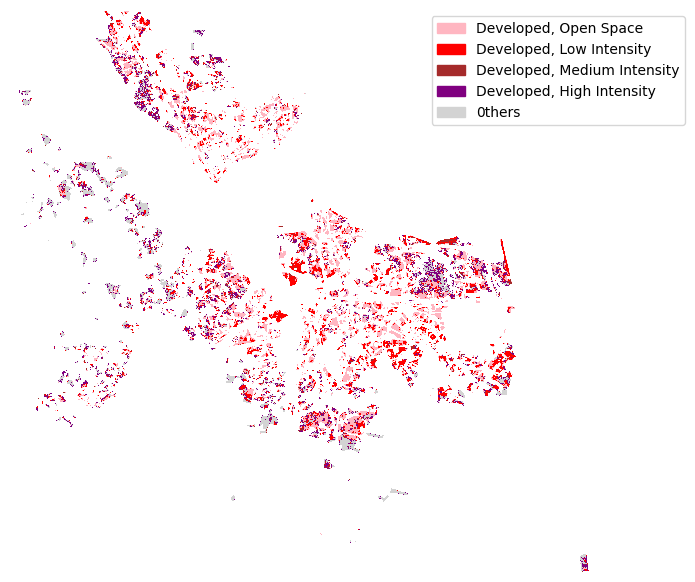

In [7]:
# Read in the land cover GeoTiff as an Xarray.Dataset
lc_data = xr.open_dataset("./AIST_censusData/osm_NLCD_2019.tif")

# Convert to DataArray
lc_array = lc_data.to_array().squeeze()

# Plot the 2019, Open Street Map masked NLCD data
# Create a color map and call specific classification for visualization
cmap = ListedColormap(["white", "lightpink", "red", "brown", "purple", "lightgray"])
norm = colors.BoundaryNorm([11, 21, 22, 23, 24, 31, 52], 7)  # This define the classes

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(lc_array, cmap=cmap, norm=norm)
legend_labels = {
    "lightpink": "Developed, Open Space",  # Create a legend to indicate the land use land cover type
    "red": "Developed, Low Intensity",
    "brown": "Developed, Medium Intensity",
    "purple": "Developed, High Intensity",
    "lightgray": "0thers"
}
patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
ax.legend(handles=patches, bbox_to_anchor=(1.10, 1), facecolor="white")
ax.set_axis_off()  # Hide the X and Y because imshow does not plot with UTM X and Y values properly
plt.show()

In the above land cover plot, we can highlight a few things. The first is the north most set of communities where Hampton, Virginia is located along with several other counties. Moving south, we run into Norfolk in the middle and Virginia Beach to the right, or East. At the bottom right of the plot, we see a small beach community. Let's see where the EPA IDM tool allocates the population using this land cover grid as ancillary data. 

### Analysis parameters
Parameters to run the notebook:
- popFeat_path = the path to the feature class
- popCountField = the name of the total population (or other total count) variable in the feature class
- popKeyField = the unique identifier for each census block or tract
- ancRaster_path = the raster to be used to apply the dasymetric mapping technique, which is typically a land cover raster 
- out_dir = where you want the results saved to
   - <b> Note: </b> there are many more than these and see the link below for a full list.

 

The **only** modifications made to the EPA's IDM tool were a couple of print statements to ensure the discrete data from land cover are being read in correctly. 

In [10]:
# Load the AIST data for the EPA tool
popFeat_path = "./AIST_censusData/AIST_regionCen_2020_clip.shp"  #We will use the polygons that have been clipped to the Open Street Map (OSM) residential areas
popCountField = 'P1_001M' #'P1_001N' is total population;  #P1_001M is medically fragile
popKeyField = 'unique_id' #this is used instead of the GEOID
ancRaster_path = './AIST_censusData/osm_NLCD_2019.tif' #Used to match the land cover allocation from Tobler's Python functions
out_dir = './output_medPop_AIST/' #'./output_ches_totPop/'
#uninhab_path = './data/uninhab_DE.shp'

In [11]:
#Run the tool
dasy_map(popFeat_path = popFeat_path, #path to population polygons
         popCountField = popCountField, #field name for population count
         popKeyField = popKeyField, #key ID 
         ancRaster_path = ancRaster_path, #path to landcover raster 
         out_dir = out_dir, #path to output folder  
         popAreaMin = 5, # was 5 for blocks, minimum number of raster cells needed inside each polygon for it to be considerded representative
         sampleMin = 10,  #was 3 for blocks, minimum number of source polygons needed to be considered representative
         percent = 0.95,  # was 0.95 for blocks, https://essd.copernicus.org/articles/14/2833/2022/essd-14-2833-2022.pdf
         #uninhab_path = uninhab_path, 
         anc_nd = 0, #no data value for raster 
         pop_nd = 0
        )

population_features path: ./AIST_censusData/AIST_regionCen_2020_clip.shp
population_count_field: P1_001M
population_key_field: unique_id
ancillary_raster: ./AIST_censusData/osm_NLCD_2019.tif
uninhabited_file: False
The minimum populated area of a representative unit is 5
The minimum sample size is 10
The percent is 0.95
The NoData value for the population raster is 0
The NoData value for the ancillary raster is 0
Creating population raster...
Creating dasymetric units...
Unique values in the raster:
0
71
41
42
43
11
81
82
52
21
22
23
24
90
31
95
Unique values in dasyRast
             Value  Count  ancID   polyID
1             55.0    2.0    0.0     10.0
2             91.0    3.0    0.0     13.0
3            221.0    8.0   11.0      9.0
4            274.0   13.0   21.0      1.0
5            298.0   38.0   22.0      1.0
...            ...    ...    ...      ...
39148  141784470.0   12.0   90.0  16749.0
39149  141801315.0    1.0   95.0  16745.0
39150  141851841.0    3.0   95.0  16748.0
39

/opt/tljh/user/lib/python3.9/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Minimum: 0.0036235761363059282
Maximum: 169.0
Range: 168.9963836669922
Mean: 0.22637252662110616
IQR Q1: 0.10312224179506302
IQR Q3: 0.2695589065551758
Median: 0.17017430067062378
bounds left: 348381.73074883263
bounds right: 427872.4531630747
bounds top: 4115219.390443106
bounds bottom: 4043088.032257203


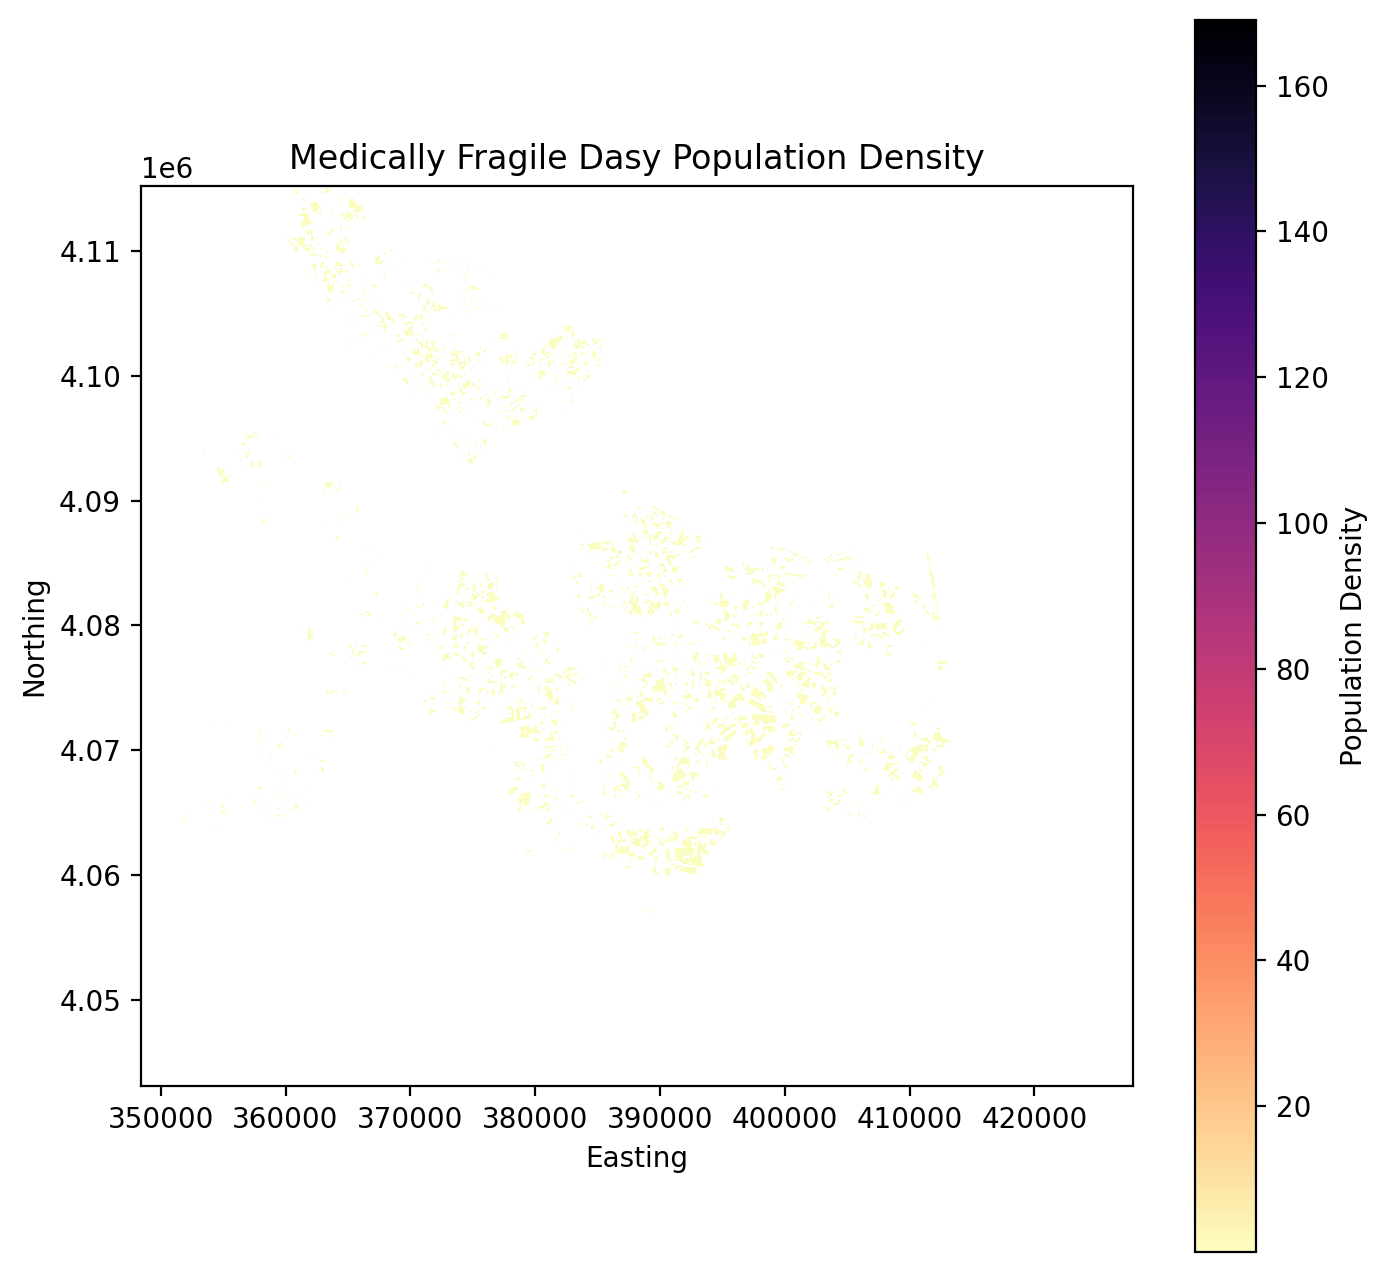

In [12]:
# File path to the GeoTIFF you want to visualize
geotiff_path = './output_medPop_AIST/DensityRaster.tif'

# Read the GeoTIFF using rasterio
with rasterio.open(geotiff_path) as src:
    # Read the raster data
    raster_data = src.read(1, masked=True)
    
    # Mask out zero values
    raster_data = np.ma.masked_where(raster_data == 0, raster_data)
    
    # Compute the minimum, maximum, range, mean, median, and mode of the filtered raster data
    data_min = raster_data.min()
    data_max = raster_data.max()
    data_range = data_max - data_min
    data_mean = raster_data.mean()
    
    # Flatten the raster data while excluding masked, NaN, and zero values
    valid_values = raster_data[~raster_data.mask] if isinstance(raster_data, np.ma.MaskedArray) else raster_data.flatten()
    valid_values = valid_values[~np.isnan(valid_values)] #& (valid_values != 0)]  # Remove NaN and zero values

    # Calculate statistics for valid values
    data_min = np.min(valid_values)
    data_max = np.max(valid_values)
    data_range = data_max - data_min
    data_mean = np.mean(valid_values)

    # Calculate IQR Q1 and Q3 for valid values
    Q1 = np.percentile(valid_values, 25)
    Q3 = np.percentile(valid_values, 75)
    med = np.median(valid_values)

    print(f"Minimum: {data_min}")
    print(f"Maximum: {data_max}")
    print(f"Range: {data_range}")
    print(f"Mean: {data_mean}")
    print(f"IQR Q1: {Q1}")
    print(f"IQR Q3: {Q3}")
    print(f"Median: {med}")
    
    print(f"bounds left: {src.bounds.left}")
    print(f"bounds right: {src.bounds.right}")
    print(f"bounds top: {src.bounds.top}")
    print(f"bounds bottom: {src.bounds.bottom}")
         
    
    # Plotting
    f, ax = plt.subplots(figsize=(8, 8), dpi = 200)
    img = ax.imshow(raster_data, cmap="magma_r", extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])
    
    # Set the limits to zoom in on a specific region (adjust values accordingly)
    #ax.set_xlim(345000, 415000)  # Set the limits for x-axis
    #ax.set_ylim(4043088, 4095219)  # Set the limits for y-axis
    
    
    plt.colorbar(img, label='Population Density')
    plt.title('Medically Fragile Dasy Population Density')
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.grid(False)

It is difficult to distinguish key areas with this type of color ramp. Below, we will classify the data into quantiles to help make hotspots stand out. 

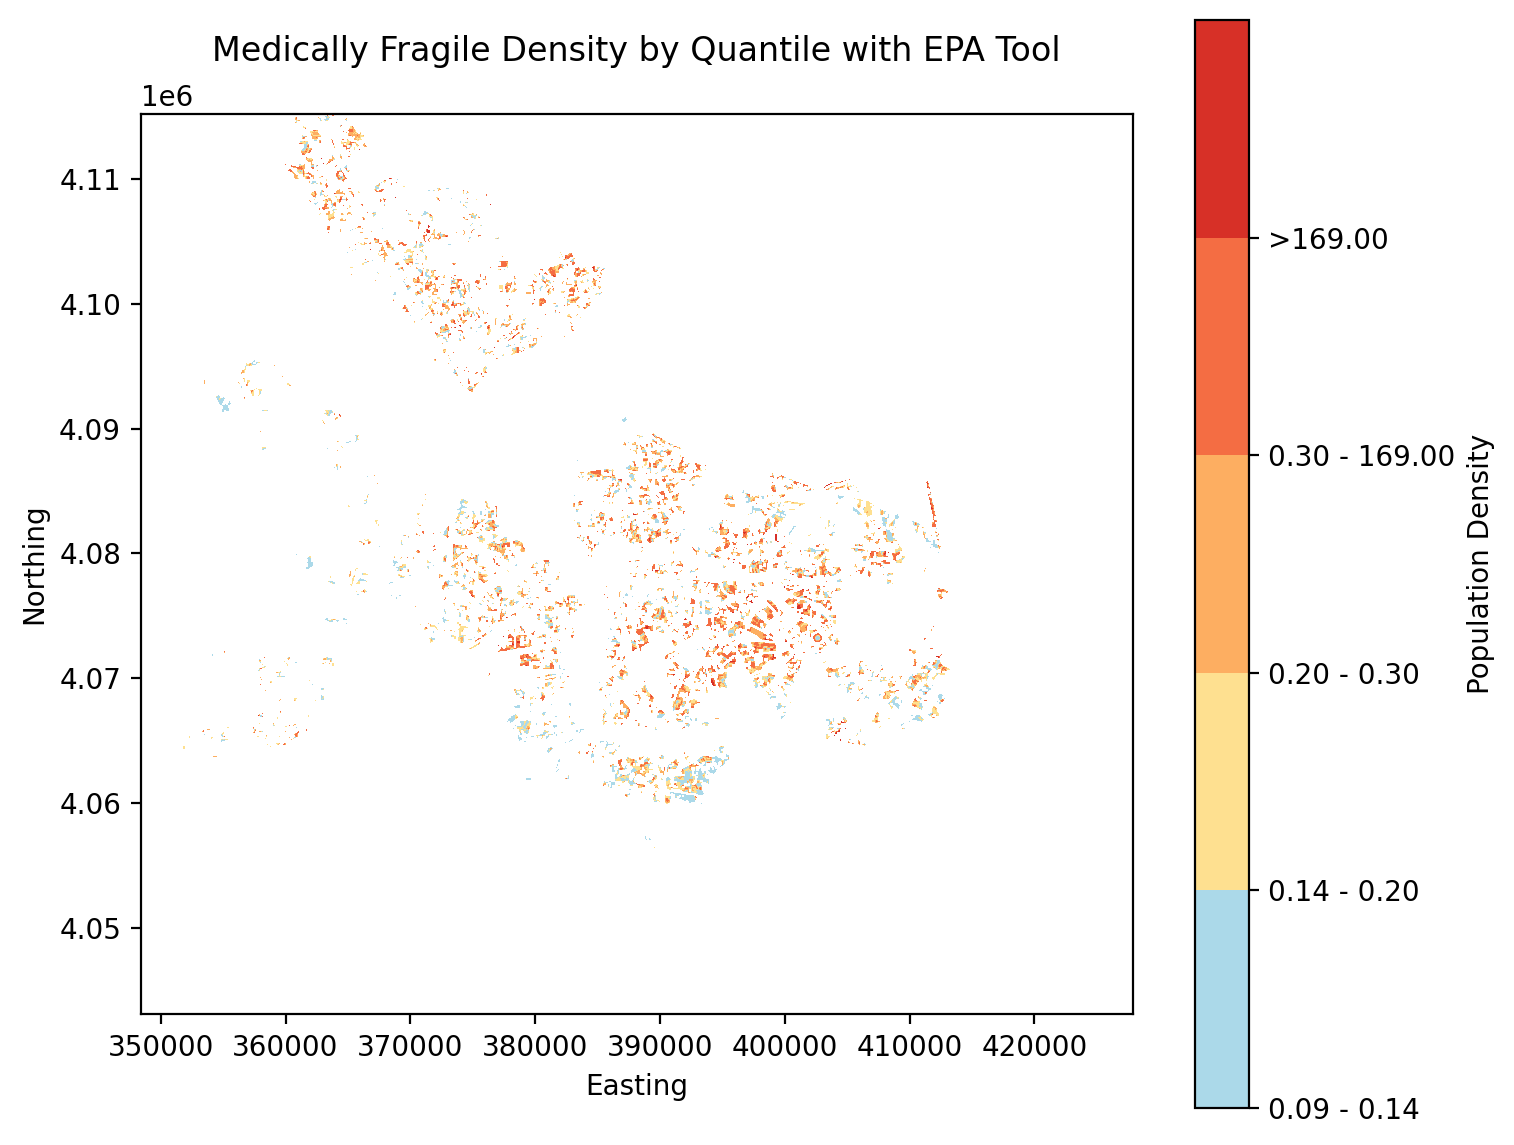

In [13]:
from matplotlib.colors import BoundaryNorm, ListedColormap

# File path to the GeoTIFF you want to visualize
geotiff_path = './output_medPop_AIST/DensityRaster.tif'

# Read the GeoTIFF using rasterio
with rasterio.open(geotiff_path) as src:
    # Read the raster data
    raster_data = src.read(1, masked=True)
    
    # Mask out zero values
    raster_data = np.ma.masked_where(raster_data == 0, raster_data)

    # Calculate quantiles
    values = raster_data[~raster_data.mask]
    quantiles = np.percentile(values, [20, 40, 60, 80, 100])

    # Assign values to quantile classes
    classes = np.digitize(raster_data, quantiles)

    # Mask NoData values
    classes = np.ma.masked_where(raster_data.mask, classes)

    # Define the reversed colormap and norm
    colors = ['#abd9e9', '#fee090', '#fdae61', '#f46d43', '#d73027']  
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(len(quantiles) + 1), len(colors))

    # Create the plot with zoom
    fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
    img = ax.imshow(classes, cmap=cmap, norm=norm, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])

    # Set the limits to zoom in on a specific region
    #ax.set_xlim(365000, 400000)  # Set the limits for x-axis
    #ax.set_ylim(4043088, 4095219)  # Set the limits for y-axis

    # Create colorbar with quantile ranges as labels
    tick_labels = [f'{quantiles[i]:.2f} - {quantiles[i+1]:.2f}' for i in range(len(quantiles) - 1)]
    tick_labels.append(f'>{quantiles[-1]:.2f}')  # Ensure the last label shows the highest quantile

    cbar = plt.colorbar(img, ticks=np.arange(len(quantiles)), label='Population Density')
    cbar.ax.set_yticklabels(tick_labels)
    
    fig.subplots_adjust(bottom=0.2)

    plt.title('Medically Fragile Density by Quantile with EPA Tool', y=1.04)
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.grid(False)
    plt.show()

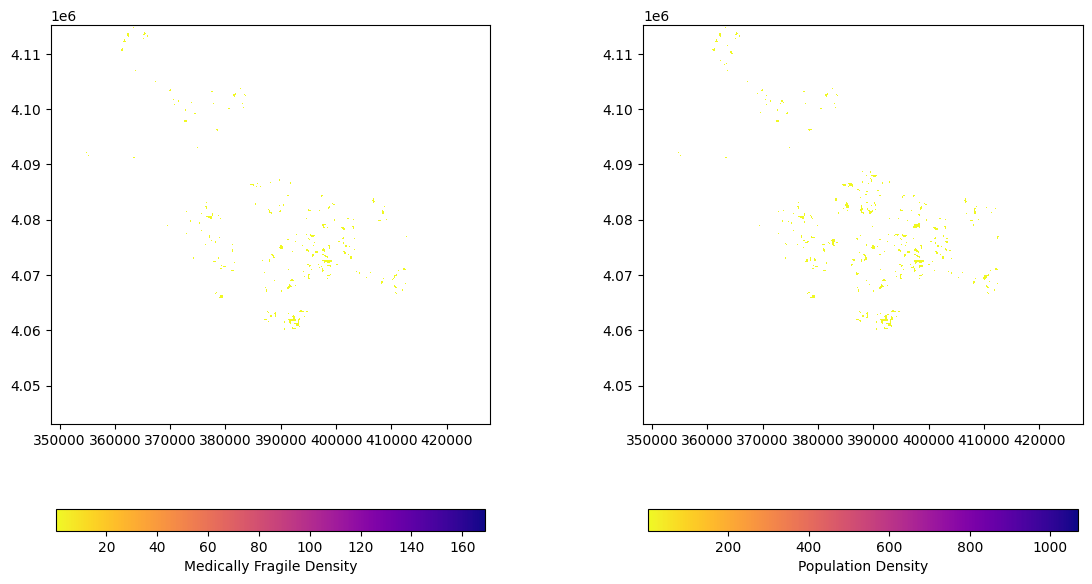

In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import get_cmap

# File paths for both rasters
input_tif_MedFrag = './output_medPop_AIST/DensityRaster.tif'
input_tif_TotPop = './output_totPop_AIST/DensityRaster.tif'

# Read the input GeoTIFFs
with rasterio.open(input_tif_MedFrag) as src1, rasterio.open(input_tif_TotPop) as src2:
    
    # Read the data as an array for both rasters
    data1 = src1.read(1, masked=True)  # input_tif_MedFrag
    data2 = src2.read(1, masked=True)  # input_tif_TotPop

    # Mask out zero values
    raster_data_1 = np.ma.masked_where(data1 == 0, data1)
    raster_data_2 = np.ma.masked_where(data2 == 0, data2)

    # Calculate quantiles
    values_1 = raster_data_1[~raster_data_1.mask]
    quantiles_1 = np.percentile(values_1, [20, 40, 60, 80, 100])
    values_2 = raster_data_2[~raster_data_2.mask]
    quantiles_2 = np.percentile(values_2, [20, 40, 60, 80, 100])

    # Get the 'rdpu' colormap from matplotlib
    cmap1 = get_cmap('plasma_r')
    cmap2 = get_cmap('plasma_r')

    # Plot the rasters side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first raster
    img1 = ax1.imshow(raster_data_1, cmap=cmap1, extent=rasterio.plot.plotting_extent(src1), vmin=quantiles_1[0], vmax=quantiles_1[-1])
    cbar1 = plt.colorbar(img1, ax=ax1, orientation='horizontal', shrink=0.8)
    cbar1.set_label('Medically Fragile Density')

    # Plot for the second raster
    img2 = ax2.imshow(raster_data_2, cmap=cmap2, extent=rasterio.plot.plotting_extent(src2), vmin=quantiles_2[0], vmax=quantiles_2[-1])
    cbar2 = plt.colorbar(img2, ax=ax2, orientation='horizontal', shrink=0.8)
    cbar2.set_label('Population Density')

    # Set the limits to zoom in on a specific region
    #ax1.set_xlim(365000, 400000)  # Set the limits for x-axis for the first subplot
    #ax1.set_ylim(4045088, 4085219)  # Set the limits for y-axis for the first subplot

    #ax2.set_xlim(365000, 400000)  # Set the limits for x-axis for the second subplot
    #ax2.set_ylim(4045088, 4085219)  # Set the limits for y-axis for the second subplot

    # Increase spacing of x-axis ticks
    #ax1.set_xticks(np.arange(365000, 400000, 10000))  # Adjust the increment value as needed
    #ax2.set_xticks(np.arange(365000, 400000, 10000))  # Adjust the increment value as needed

    # Adjust the space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.tight_layout()
    plt.show()



We can see how the medically fragile's modeled distribution from the EPA IDM tool is similar to the distribution from the explore tool and picks up on the LISA clusters, especially in the north east of Chesapeake and some in the middle. This tool allows for the generation of population grids which has the potential for more nuanced health vulnerability analyses. 

## Additional information

<b>License:</b> The code in this notebook is licensed under the Apache License, Version 2.0. Virginia Data Cube is licensed under the Creative Commons by Attribution 4.0 license.

<b>Contact:</b> If you need assistance, please post a question on the Open Data Cube Slack channel or on the GIS Stack Exchange using the open-data-cube tag (you can view previously asked questions there). If you would like to report an issue with this notebook, you can file one on Github.

<b>Last modified:</b> May 2024

<b>Compatible datacube version:</b>

In [15]:
print(datacube.__version__)

1.8.13


## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 